# BaseLine Transformer model

Caution: This is not a usual use case of Transformer.

Transformer developed by Google usually use Embeddeding Layer to represents a target such as a word.

In this model, I use OHLC as a state vector though we can take same approch for finance data.
As d_model is very low, this would be a base line of Transformer.

Parameters:
- Input:  ohlc_df.iloc[index] while observation length
- Target: ohlc_df.iloc[index+observation_length] while prediction length

## Prepare Data

Since we shouldn't expose data obtained from other service, csv is not committed to this repository.
Please preprare your data and load it.

In [1]:
import os
ohlc_column = ['open','high','low','close']
file_path = os.path.abspath('../Data/mt5_USDJPY_min30.csv')

In [2]:
import pandas as pd
df = pd.read_csv(file_path)
df

,time,open,high,low,close,tick_volume,spread,real_volume
0,2014-07-07 08:30:00,102.086,102.122,102.081,102.102,738,3,0
1,2014-07-07 09:00:00,102.102,102.146,102.098,102.113,1036,3,0
2,2014-07-07 09:30:00,102.113,102.115,102.042,102.044,865,3,0
3,2014-07-07 10:00:00,102.047,102.052,102.005,102.019,983,3,0
4,2014-07-07 10:30:00,102.017,102.025,101.918,101.941,1328,3,0
...,...,...,...,...,...,...,...,...
100715,2022-08-12 21:30:00,133.461,133.506,133.439,133.484,1125,3,0
100716,2022-08-12 22:00:00,133.484,133.530,133.437,133.475,1277,3,0
100717,2022-08-12 22:30:00,133.475,133.486,133.433,133.483,1506,3,0
100718,2022-08-12 23:00:00,133.484,133.536,133.465,133.521,1038,3,0


## Basic Dataset Definition

In [3]:
import math
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import (TransformerDecoder, TransformerDecoderLayer,
                      TransformerEncoder, TransformerEncoderLayer)
from torch.utils.data import DataLoader
from tqdm import tqdm

In [32]:
import sys

module_path = os.path.abspath("../..")
sys.path.append(module_path)

from Dataset.transformer import FeatureDataset
import fprocess

## Define Model

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.05):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(-2)
        #pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, src, tgt):
        src_pos = src.size(0)
        tgt_pos = src_pos + tgt.size(0) - 1
        return self.dropout(src + self.pe[:src_pos, :]), self.dropout(tgt + self.pe[src_pos-1:tgt_pos, :])

In [6]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        feature_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.positional_encoding = PositionalEncoding(feature_size, dropout=dropout)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

    def forward(
        self, src: Tensor, tgt: Tensor, mask_tgt: Tensor,
        mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        
        src, tgt = self.positional_encoding(src, tgt)
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return outs

## Define Training Methods

In [7]:
def train(model, ds, optimizer, criterion, batch_size, device):
    
    model.train()
    ds.train()
    losses = 0
    
    length = 0.0
    end_index = len(ds)
    for index in tqdm(range(0, end_index, batch_size)):
        if end_index - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, tgt=input_tgt,  mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [8]:
def evaluate(model, ds, criterion, batch_size, device):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds), batch_size):
        if len(ds) - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)

        logits = model(
            src=src, tgt=input_tgt, mask_tgt=mask_tgt,
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        losses += loss.item()
        
    return losses / length

## Training

In [9]:
ohlc_column = ['open','high','low','close']
#volume_column = ["tick_volume"]
#columns = ohlc_column+volume_column
columns = ohlc_column

log_p = fprocess.LogPreProcess(columns=ohlc_column)
diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
ohlc_pre_process = [log_p, diff_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_name = "finance_basic_transfomer"
model_version = "1"

#Dataset parameters
batch_size = 64
observation_length = 30
prediction_length = 10

ds = FeatureDataset(df, columns, processes=processes,
             observation_length=observation_length, prediction_length=prediction_length)

In [11]:
# check outputs represents (data_length, chunk_size, feature_size)
ds.train()
for index in range(0, len(ds)-16, 16):
    src, tgt = ds[index: index+16]
    continue
print(src.shape, tgt.shape)

torch.Size([30, 16, 4]) torch.Size([11, 16, 4])


In [12]:
feature_size = 4

# Hyper parameters
nhead = 1
dim_feedforward = 1000
num_encoder_layers = 6
num_decoder_layers = 6
dropout = 0.01

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

In [13]:
lr = 0.00005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [14]:
epoch = 500
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        device=device
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,
        batch_size=batch_size, device=device
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

100%|█████████▉| 1101/1102 [08:27<00:00,  2.17it/s]


[1/500] train loss: 0.8091842407, valid loss: 0.7285565459  27s] count: 0, **


100%|█████████▉| 1101/1102 [08:24<00:00,  2.18it/s]


[2/500] train loss: 0.6581299651, valid loss: 0.5877457113  24s] count: 0, **


100%|█████████▉| 1101/1102 [08:06<00:00,  2.26it/s]


[3/500] train loss: 0.5217742690, valid loss: 0.4579240387  6s] count: 0, **


100%|█████████▉| 1101/1102 [08:02<00:00,  2.28it/s]


[4/500] train loss: 0.4014476198, valid loss: 0.3468646330  3s] count: 0, **


100%|█████████▉| 1101/1102 [07:17<00:00,  2.52it/s]


[5/500] train loss: 0.2989568525, valid loss: 0.2529477035  17s] count: 0, **


100%|█████████▉| 1101/1102 [07:55<00:00,  2.32it/s]


[6/500] train loss: 0.2132053447, valid loss: 0.1752312703  56s] count: 0, **


100%|█████████▉| 1101/1102 [07:52<00:00,  2.33it/s]


[7/500] train loss: 0.1437016469, valid loss: 0.1141124351  53s] count: 0, **


100%|█████████▉| 1101/1102 [07:28<00:00,  2.45it/s]


[8/500] train loss: 0.0909118540, valid loss: 0.0694108857  29s] count: 0, **


100%|█████████▉| 1101/1102 [07:29<00:00,  2.45it/s]


[9/500] train loss: 0.0535441477, valid loss: 0.0389217476  29s] count: 0, **


100%|█████████▉| 1101/1102 [07:28<00:00,  2.46it/s]


[10/500] train loss: 0.0289269585, valid loss: 0.0196340735  28s] count: 0, **


100%|█████████▉| 1101/1102 [07:31<00:00,  2.44it/s]


[11/500] train loss: 0.0139584954, valid loss: 0.0084989027  32s] count: 0, **


100%|█████████▉| 1101/1102 [07:27<00:00,  2.46it/s]


[12/500] train loss: 0.0058990128, valid loss: 0.0031312718  28s] count: 0, **


100%|█████████▉| 1101/1102 [07:08<00:00,  2.57it/s]


[13/500] train loss: 0.0025372335, valid loss: 0.0013737952  9s] count: 0, **


100%|█████████▉| 1101/1102 [07:38<00:00,  2.40it/s]


[14/500] train loss: 0.0016838942, valid loss: 0.0011008772  38s] count: 0, **


100%|█████████▉| 1101/1102 [07:54<00:00,  2.32it/s]


[15/500] train loss: 0.0015938807, valid loss: 0.0010887788  55s] count: 0, **


100%|█████████▉| 1101/1102 [07:44<00:00,  2.37it/s]


[16/500] train loss: 0.0015893154, valid loss: 0.0010885016  45s] count: 0, **


100%|█████████▉| 1101/1102 [06:54<00:00,  2.66it/s]


[17/500] train loss: 0.0015879614, valid loss: 0.0010887920  54s] count: 0, 


100%|█████████▉| 1101/1102 [06:24<00:00,  2.86it/s]


[18/500] train loss: 0.0015872501, valid loss: 0.0010888775  25s] count: 1, 


100%|█████████▉| 1101/1102 [06:25<00:00,  2.86it/s]


[19/500] train loss: 0.0015866232, valid loss: 0.0010888970  26s] count: 2, 


100%|█████████▉| 1101/1102 [06:56<00:00,  2.64it/s]


[20/500] train loss: 0.0015861536, valid loss: 0.0010887473  57s] count: 3, 


100%|█████████▉| 1101/1102 [07:52<00:00,  2.33it/s]


[21/500] train loss: 0.0015858036, valid loss: 0.0010887539  52s] count: 4, 


100%|█████████▉| 1101/1102 [07:45<00:00,  2.37it/s]


[22/500] train loss: 0.0015856441, valid loss: 0.0010887138  45s] count: 5, 


100%|█████████▉| 1101/1102 [07:37<00:00,  2.41it/s]


[23/500] train loss: 0.0015853862, valid loss: 0.0010885514  37s] count: 6, 


100%|█████████▉| 1101/1102 [07:24<00:00,  2.48it/s]


[24/500] train loss: 0.0015851819, valid loss: 0.0010885444  24s] count: 7, 


100%|█████████▉| 1101/1102 [07:24<00:00,  2.48it/s]


[25/500] train loss: 0.0015850298, valid loss: 0.0010886731  25s] count: 8, 


100%|█████████▉| 1101/1102 [07:23<00:00,  2.48it/s]


[26/500] train loss: 0.0015849204, valid loss: 0.0010885901  24s] count: 9, 


100%|█████████▉| 1101/1102 [07:34<00:00,  2.42it/s]


[27/500] train loss: 0.0015848255, valid loss: 0.0010885851  35s] count: 10, 


In [38]:
torch.save(best_model.state_dict(), f'./{model_name}_v{model_version}.torch')

## Validation

In [14]:
model_version = 1
model.load_state_dict(torch.load(f'./{model_name}_v{model_version}.torch'))

<All keys matched successfully>

In [15]:
def prediction(inputs):

    preds = torch.zeros(1, inputs.size(1), feature_size, device=device)
    preds[0, :, :] = inputs[-1,:, :]
    while preds.size(0) <= prediction_length:
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(preds.size(0)).to(device)
        out = model(src=inputs, tgt=preds,  mask_tgt=tgt_mask)
        preds = torch.cat([preds, out[-1:]], dim=0)
    return preds

In [16]:
src, tgt = ds[:16]

In [70]:
tgt_values = tgt.cpu().detach().numpy()
tgt_values.shape

(11, 16, 4)

In [71]:
src_values = src.cpu().detach().numpy()

In [72]:
r_data = ds.revert(src_values, [index for index in range(0, 16)], is_tgt=False)

In [73]:
# reverted open values
r_data[:, 0, 0]

array([106.59    , 106.520996, 106.520996, 106.54599 , 106.47799 ,
       106.471985, 106.43199 , 106.42899 , 106.383995, 106.383995,
       106.352   , 106.32399 , 106.104996, 106.255974, 106.168015,
       106.222   , 106.01402 , 106.10298 , 105.99102 , 106.06099 ,
       106.081985, 106.09301 , 106.22402 , 106.20001 , 106.223   ,
       106.30302 , 106.205986, 106.29601 , 106.246   , 106.22897 ],
      dtype=float32)

In [66]:
index = ds.get_actual_index([0])[0]
df[ohlc_column].iloc[index:index+30]

,open,high,low,close
63087,106.590,106.623,106.500,106.520
63088,106.521,106.588,106.517,106.521
63089,106.521,106.552,106.484,106.546
63090,106.546,106.546,106.461,106.478
63091,106.478,106.495,106.443,106.473
63092,106.472,106.473,106.389,106.432
63093,106.432,106.463,106.428,106.428
63094,106.429,106.457,106.374,106.384
63095,106.384,106.447,106.365,106.382
63096,106.384,106.415,106.350,106.352


In [74]:
tgt_values = tgt.cpu().detach().numpy()

In [75]:
tgt_r_data = ds.revert(tgt_values, [index for index in range(0, 16)], is_tgt=True)

In [76]:
# reverted open values
tgt_r_data[:, 0, 0]

array([106.22897 , 106.25102 , 106.26399 , 106.27302 , 106.205986,
       106.136986, 105.87499 , 106.07202 , 105.82498 , 105.70298 ,
       105.68801 ], dtype=float32)

In [77]:
index = ds.get_actual_index([0])[0]
df[ohlc_column].iloc[index+29:index+40]

,open,high,low,close
63116,106.229,106.281,106.219,106.251
63117,106.251,106.285,106.218,106.263
63118,106.264,106.284,106.248,106.273
63119,106.273,106.283,106.207,106.208
63120,106.206,106.241,106.089,106.135
63121,106.137,106.143,105.833,105.875
63122,105.875,106.069,105.701,106.069
63123,106.072,106.101,105.806,105.825
63124,105.825,105.864,105.650,105.703
63125,105.703,105.881,105.589,105.688


In [35]:
ds.eval()
model.eval()

split_factor = 300
split_index = int(len(ds)/split_factor)

for factor in range(0, split_factor):
    if factor == split_factor-1:
        val_inp, val_ans = ds[split_index * factor :]
        ndx = slice(split_index * factor, len(ds))
    else:
        val_inp, val_ans = ds[split_index * factor : split_index * (factor+1)]
        ndx = slice(split_index * factor, split_index * (factor+1))
        
    preds = prediction(val_inp)
    pre_values = preds.cpu().detach().numpy()
    
    ohlc = ds.revert(pre_values, ndx, True)
    
    if factor == 0:
        ohlc_pre = ohlc
    else:
        ohlc_pre = np.append(ohlc_pre, ohlc, axis=1)
    
    ans_values = val_ans.cpu().detach().numpy()
    
    temp_ohlc = ds.revert(ans_values, ndx, True)
    
    if factor == 0:
        ohlc_ans = temp_ohlc
    else:
        ohlc_ans = np.append(ohlc_ans, temp_ohlc, axis=1)

In [18]:
print(ohlc_pre.shape, ohlc_ans.shape)

(11, 30164, 4) (11, 30164, 4)


[]

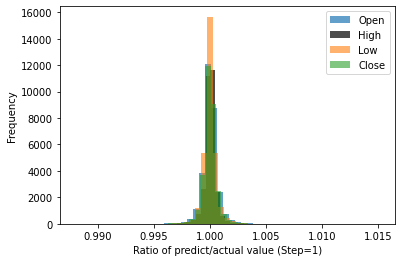

In [19]:
step=1
plt.hist(ohlc_pre[step, :, 0]/ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1]/ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2]/ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3]/ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

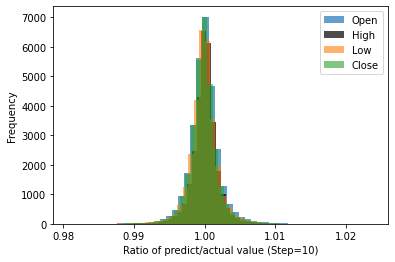

In [20]:
step=10
plt.hist(ohlc_pre[step, :, 0]/ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1]/ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2]/ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3]/ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [21]:
print("==============Mean============")
print("Open", np.mean(ohlc_pre[:, :, 0]/ohlc_ans[:, :, 0], axis=1))
print("High", np.mean(ohlc_pre[:, :, 1]/ohlc_ans[:, :, 1], axis=1))
print("Low", np.mean(ohlc_pre[:, :, 2]/ohlc_ans[:, :, 2], axis=1))
print("Close", np.mean(ohlc_pre[:, :, 3]/ohlc_ans[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(ohlc_pre[:, :, 0]/ohlc_ans[:, :, 0], axis=1))
print("High", np.var(ohlc_pre[:, :, 1]/ohlc_ans[:, :, 1], axis=1))
print("Low", np.var(ohlc_pre[:, :, 2]/ohlc_ans[:, :, 2], axis=1))
print("Close", np.var(ohlc_pre[:, :, 3]/ohlc_ans[:, :, 3], axis=1))

==============Mean============
Open [1.         0.99999611 0.99999215 0.99998821 0.99998424 0.99998041
 0.99997657 0.99997282 0.99996899 0.9999652  0.99996152]
High [1.         1.00000855 1.00001708 1.00002559 1.00003419 1.00004284
 1.00005155 1.00006022 1.00006889 1.00007765 1.00008645]
Low [1.         0.99999144 0.99998292 0.99997434 0.99996571 0.99995719
 0.99994872 0.99994026 0.99993189 0.99992366 0.99991532]
Close [1.         0.99998693 0.99997385 0.99996078 0.99994782 0.99993487
 0.99992198 0.99990903 0.99989611 0.99988325 0.99987045]
==============Var============
Open [0.00000000e+00 5.40798553e-07 1.05561586e-06 1.59424361e-06
 2.11457189e-06 2.64702209e-06 3.18154737e-06 3.73484919e-06
 4.27708423e-06 4.81534493e-06 5.35700973e-06]
High [0.00000000e+00 2.89565526e-07 6.51417274e-07 1.01478101e-06
 1.37265861e-06 1.73481728e-06 2.09681876e-06 2.46109037e-06
 2.82339027e-06 3.18788276e-06 3.54613860e-06]
Low [0.00000000e+00 3.94314927e-07 8.61170238e-07 1.32628495e-06
 1.7735172

[]

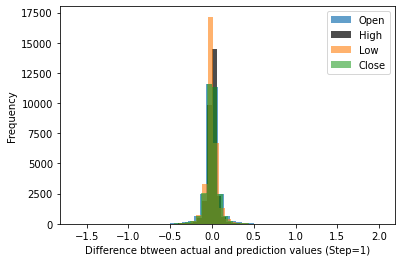

In [22]:
step=1
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

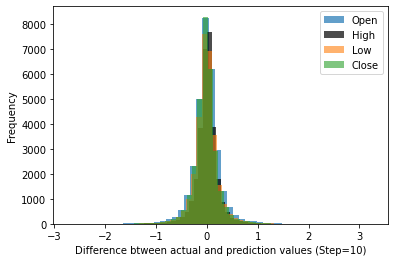

In [23]:
step=10
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [24]:
np.set_printoptions(precision=5)

print("==============Mean============")
print("Open", np.mean(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.mean(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.mean(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.var(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.var(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

==============Mean============
Open [ 0.      -0.00053 -0.00107 -0.00161 -0.00216 -0.0027  -0.00324 -0.00378
 -0.00433 -0.00488 -0.00542]
High [0.      0.0009  0.00178 0.00266 0.00355 0.00443 0.00531 0.00619 0.00706
 0.00793 0.0088 ]
Low [ 0.      -0.00104 -0.00207 -0.00311 -0.00416 -0.00519 -0.00622 -0.00725
 -0.00827 -0.00927 -0.01028]
Close [ 0.      -0.00155 -0.00309 -0.00464 -0.00617 -0.00771 -0.00923 -0.01077
 -0.0123  -0.01382 -0.01534]
==============Var============
Open [0.      0.00759 0.01492 0.02268 0.03033 0.03827 0.04636 0.05483 0.06329
 0.07176 0.08044]
High [0.      0.00398 0.00886 0.01373 0.01846 0.0232  0.02788 0.03252 0.03709
 0.04164 0.04605]
Low [0.      0.00551 0.01197 0.01842 0.02461 0.03077 0.037   0.04333 0.04965
 0.05594 0.06212]
Close [0.      0.00609 0.0119  0.01806 0.02398 0.03011 0.03621 0.04247 0.04871
 0.0549  0.06111]


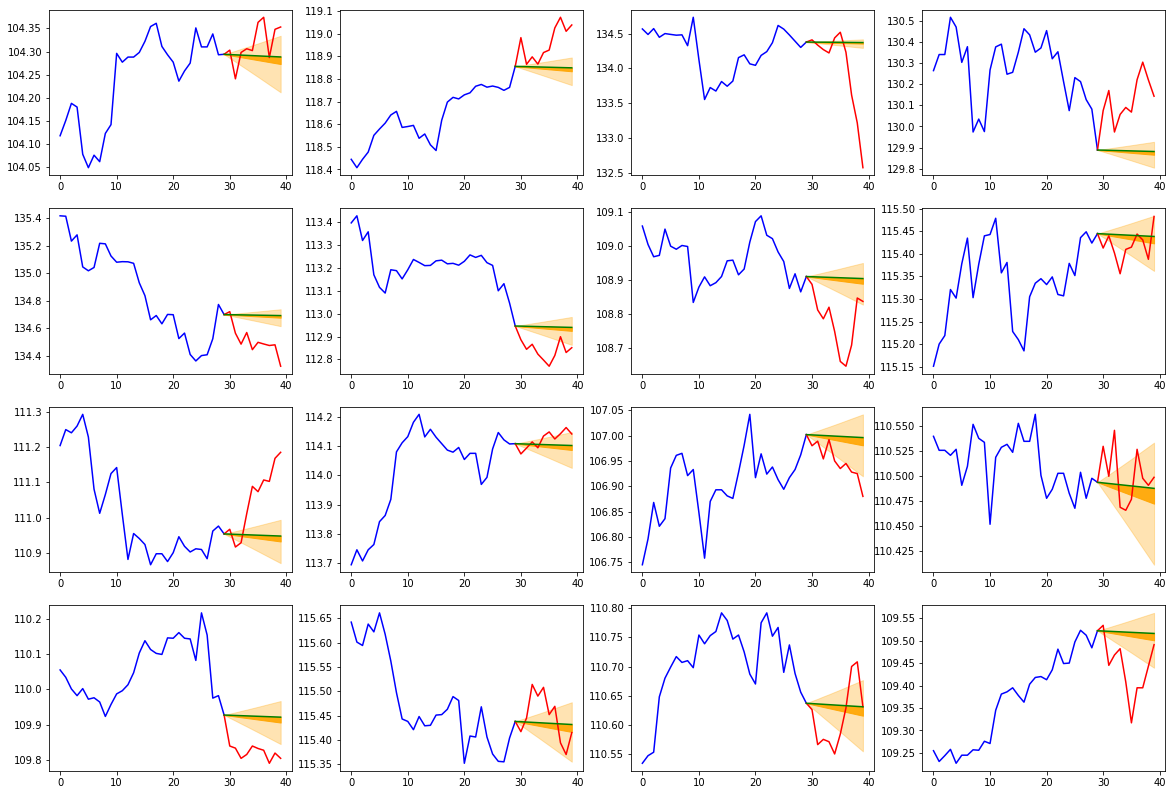

In [36]:
fig, axs = plt.subplots(4, 4, figsize=(20, 14))
close_mean = np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)
close_var = np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)

total_length = observation_length + prediction_length
x = np.arange(total_length)



for i, ax in enumerate(axs.flat):
    index = ds.get_actual_index(i)
    original_ohlc = df[ohlc_column[3]].iloc[index: index + observation_length]
    pred_value = ohlc_pre[:, i, 3]
    pred_add_mean = pred_value + close_mean
    pred_upper = pred_add_mean + close_var
    pred_lower = pred_add_mean - close_var

    ax.fill_between(x[observation_length -1:], pred_value, pred_add_mean, color="orange", alpha=0.9)
    ax.fill_between(x[observation_length -1:], pred_lower, pred_upper, color="orange", alpha=0.3)
    ax.plot(x[:observation_length], original_ohlc, color="blue")
    ax.plot(x[observation_length-1:], ohlc_ans[:, i, 3], color="red")
    ax.plot(x[observation_length-1:], pred_value, color="green")
plt.show()

# BaseLine Transformer model with Weekly Time Position

Above results seems that predictions didn't learn the position. Not sure if that caused by different scale difference or lack of features.
Next model investigate it by changing positioning encoder from sin/cos of vector position to weekky hour position.
For example, if the steps is observed on [Monday 23:00, Monday 23:30, Thuesday 00:00, Thuesday 00:00], makes it as [47, 48, 49, 50] to represents the position of the step in the week. Then convert it to Embedded vector to add it with src and tgt.

## Prepare Data

In [1]:
import os
import pandas as pd


ohlc_column = ['open','high','low','close']
file_path = os.path.abspath('../Data/mt5_USDJPY_min30.csv')
df = pd.read_csv(file_path, index_col=0, parse_dates=True)

In [2]:
import math
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import (TransformerDecoder, TransformerDecoderLayer,
                      TransformerEncoder, TransformerEncoderLayer)
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
import sys

module_path = os.path.abspath("../..")
sys.path.append(module_path)

from Dataset.transformer import TimeFeatureDataset
from fprocess import fprocess

## Define Model

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, time_size, d_model):
        super().__init__()
        self.pe = nn.Embedding(time_size, d_model)

    def forward(self,time_ids):
        position = self.pe(time_ids)
        return position

In [5]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        feature_size: int, time_size:int =  24*7*2,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.positional_encoding = PositionalEncoding(time_size=time_size, d_model=feature_size)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

    def forward(
        self,
        src: Tensor, src_time: Tensor,
        tgt: Tensor, tgt_time: Tensor,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        
        src_time = self.positional_encoding(src_time)
        src = torch.add(src, src_time)
        tgt_time = self.positional_encoding(tgt_time)
        tgt = torch.add(tgt, tgt_time)
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return outs

## Define Training Methods

In [6]:
def train(model, ds, optimizer, criterion, batch_size, device):
    
    model.train()
    ds.train()
    losses = 0
    
    length = 0.0
    end_index = len(ds)
    for index in tqdm(range(0, end_index, batch_size)):
        if end_index - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt
        
        input_tgt_time = tgt_time[:-1, :]
        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time,
            tgt=input_tgt, tgt_time=input_tgt_time,
            mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [7]:
def evaluate(model, ds, criterion, batch_size, device):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds), batch_size):
        if len(ds) - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt
        
        input_tgt_time = tgt_time[:-1, :]
        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time,
            tgt=input_tgt, tgt_time=input_tgt_time,
            mask_tgt=mask_tgt
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        losses += loss.item()
        
    return losses / length

## Training

In [8]:
ohlc_column = ['open','high','low','close']
#volume_column = ["tick_volume"]
#columns = ohlc_column+volume_column
columns = ohlc_column

log_p = fprocess.LogPreProcess(columns=ohlc_column)
diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
time_p = fprocess.WeeklyIDProcess(freq= 30, time_column= "index")
ohlc_pre_process = [log_p, diff_p, time_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_name = "finance_basic_wt_transfomer"
model_version = "1"

#Dataset parameters
batch_size = 64
observation_length = 30
prediction_length = 10

ds = TimeFeatureDataset(df, columns, time_column="index",
                        processes=processes, observation_length=observation_length,
                        prediction_length=prediction_length)

In [ ]:
# check outputs represent (data_length, chunk_size, feature_size)
ds.train()
for index in range(0, len(ds)-16, 16):
    src, tgt = ds[index: index+16]
    continue
print(src[0].shape, src[1].shape) 
print(tgt[0].shape, tgt[1].shape)

In [10]:
feature_size = 4
freq=30

# Hyper parameters
nhead = 1
dim_feedforward = 1000
num_encoder_layers = 6
num_decoder_layers = 6
dropout = 0.01


model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    time_size=24*7*(60//freq),
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

In [11]:
lr = 0.00005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [21]:
epoch = 500
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        device=device
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,
        batch_size=batch_size, device=device
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

100%|█████████▉| 1101/1102 [07:42<00:00,  2.38it/s]


[1/500] train loss: 0.6464035505, valid loss: 0.5727602388  43s] count: 0, **


100%|█████████▉| 1101/1102 [08:37<00:00,  2.13it/s]


[2/500] train loss: 0.5075120605, valid loss: 0.4443469930  38s] count: 0, **


100%|█████████▉| 1101/1102 [07:42<00:00,  2.38it/s]


[3/500] train loss: 0.3875755149, valid loss: 0.3322794394  42s] count: 0, **


100%|█████████▉| 1101/1102 [07:34<00:00,  2.42it/s]


[4/500] train loss: 0.2836382845, valid loss: 0.2371084507  35s] count: 0, **


100%|█████████▉| 1101/1102 [07:32<00:00,  2.43it/s]


[5/500] train loss: 0.1979684614, valid loss: 0.1609745499  32s] count: 0, **


100%|█████████▉| 1101/1102 [07:33<00:00,  2.43it/s]


[6/500] train loss: 0.1309726865, valid loss: 0.1028516913  34s] count: 0, **


100%|█████████▉| 1101/1102 [07:40<00:00,  2.39it/s]


[7/500] train loss: 0.0810544946, valid loss: 0.0608191835  41s] count: 0, **


100%|█████████▉| 1101/1102 [08:28<00:00,  2.17it/s]


[8/500] train loss: 0.0461425851, valid loss: 0.0326285122  28s] count: 0, **


100%|█████████▉| 1101/1102 [08:39<00:00,  2.12it/s]


[9/500] train loss: 0.0237399911, valid loss: 0.0155066199  40s] count: 0, **


100%|█████████▉| 1101/1102 [08:32<00:00,  2.15it/s]


[10/500] train loss: 0.0108470523, valid loss: 0.0063161893  33s] count: 0, **


100%|█████████▉| 1101/1102 [08:05<00:00,  2.27it/s]


[11/500] train loss: 0.0044642591, valid loss: 0.0023152194  5s] count: 0, **


100%|█████████▉| 1101/1102 [07:45<00:00,  2.37it/s]


[12/500] train loss: 0.0021101006, valid loss: 0.0012155448  45s] count: 0, **


100%|█████████▉| 1101/1102 [07:51<00:00,  2.33it/s]


[13/500] train loss: 0.0016274941, valid loss: 0.0010919969  52s] count: 0, **


100%|█████████▉| 1101/1102 [07:33<00:00,  2.43it/s]


[14/500] train loss: 0.0015908323, valid loss: 0.0010885883  34s] count: 0, **


100%|█████████▉| 1101/1102 [06:49<00:00,  2.69it/s]


[15/500] train loss: 0.0015889865, valid loss: 0.0010884742  49s] count: 0, **


100%|█████████▉| 1101/1102 [06:53<00:00,  2.66it/s]


[16/500] train loss: 0.0015877757, valid loss: 0.0010886868  54s] count: 0, 


100%|█████████▉| 1101/1102 [07:04<00:00,  2.59it/s]


[17/500] train loss: 0.0015870489, valid loss: 0.0010886116  4s] count: 1, 


100%|█████████▉| 1101/1102 [08:33<00:00,  2.14it/s]


[18/500] train loss: 0.0015864491, valid loss: 0.0010884529  34s] count: 2, **


100%|█████████▉| 1101/1102 [06:51<00:00,  2.68it/s]


[19/500] train loss: 0.0015860476, valid loss: 0.0010885116  51s] count: 0, 


100%|█████████▉| 1101/1102 [07:53<00:00,  2.33it/s]


[20/500] train loss: 0.0015857643, valid loss: 0.0010884512  53s] count: 1, **


100%|█████████▉| 1101/1102 [07:48<00:00,  2.35it/s]


[21/500] train loss: 0.0015855309, valid loss: 0.0010884298  48s] count: 0, **


100%|█████████▉| 1101/1102 [07:52<00:00,  2.33it/s]


[22/500] train loss: 0.0015852774, valid loss: 0.0010884611  53s] count: 0, 


100%|█████████▉| 1101/1102 [08:24<00:00,  2.18it/s]


[23/500] train loss: 0.0015851760, valid loss: 0.0010884388  24s] count: 1, 


100%|█████████▉| 1101/1102 [07:38<00:00,  2.40it/s]


[24/500] train loss: 0.0015793790, valid loss: 0.0010630019  39s] count: 2, **


100%|█████████▉| 1101/1102 [07:31<00:00,  2.44it/s]


[25/500] train loss: 0.0015406045, valid loss: 0.0010394662  32s] count: 0, **


100%|█████████▉| 1101/1102 [07:31<00:00,  2.44it/s]


[26/500] train loss: 0.0015221886, valid loss: 0.0010256651  31s] count: 0, **


100%|█████████▉| 1101/1102 [07:32<00:00,  2.43it/s]


[27/500] train loss: 0.0015075942, valid loss: 0.0010134743  33s] count: 0, **


100%|█████████▉| 1101/1102 [07:28<00:00,  2.45it/s]


[28/500] train loss: 0.0014916361, valid loss: 0.0009999666  29s] count: 0, **


100%|█████████▉| 1101/1102 [07:31<00:00,  2.44it/s]


[29/500] train loss: 0.0014743123, valid loss: 0.0009852819  31s] count: 0, **


100%|█████████▉| 1101/1102 [07:29<00:00,  2.45it/s]


[30/500] train loss: 0.0014559487, valid loss: 0.0009719812  30s] count: 0, **


100%|█████████▉| 1101/1102 [07:28<00:00,  2.45it/s]


[31/500] train loss: 0.0014352371, valid loss: 0.0009564234  29s] count: 0, **


100%|█████████▉| 1101/1102 [07:29<00:00,  2.45it/s]


[32/500] train loss: 0.0014168974, valid loss: 0.0009425074  30s] count: 0, **


100%|█████████▉| 1101/1102 [07:29<00:00,  2.45it/s]


[33/500] train loss: 0.0013943522, valid loss: 0.0009299352  29s] count: 0, **


100%|█████████▉| 1101/1102 [07:27<00:00,  2.46it/s]


[34/500] train loss: 0.0013775015, valid loss: 0.0009176375  27s] count: 0, **


100%|█████████▉| 1101/1102 [07:30<00:00,  2.44it/s]


[35/500] train loss: 0.0013596678, valid loss: 0.0009071761  31s] count: 0, **


100%|█████████▉| 1101/1102 [07:30<00:00,  2.44it/s]


[36/500] train loss: 0.0013455810, valid loss: 0.0008956872  31s] count: 0, **


100%|█████████▉| 1101/1102 [07:29<00:00,  2.45it/s]


[37/500] train loss: 0.0013313496, valid loss: 0.0008867897  29s] count: 0, **


100%|█████████▉| 1101/1102 [07:28<00:00,  2.46it/s]


[38/500] train loss: 0.0013178483, valid loss: 0.0008757406  28s] count: 0, **


100%|█████████▉| 1101/1102 [07:33<00:00,  2.43it/s]


[39/500] train loss: 0.0013075667, valid loss: 0.0008669777  33s] count: 0, **


100%|█████████▉| 1101/1102 [07:36<00:00,  2.41it/s]


[40/500] train loss: 0.0012962557, valid loss: 0.0008598687  37s] count: 0, **


100%|█████████▉| 1101/1102 [07:30<00:00,  2.44it/s]


[41/500] train loss: 0.0012827396, valid loss: 0.0008540199  31s] count: 0, **


100%|█████████▉| 1101/1102 [07:29<00:00,  2.45it/s]


[42/500] train loss: 0.0012748484, valid loss: 0.0008480722  29s] count: 0, **


100%|█████████▉| 1101/1102 [07:31<00:00,  2.44it/s]


[43/500] train loss: 0.0012650371, valid loss: 0.0008412504  31s] count: 0, **


100%|█████████▉| 1101/1102 [07:29<00:00,  2.45it/s]


[44/500] train loss: 0.0012569748, valid loss: 0.0008368908  29s] count: 0, **


100%|█████████▉| 1101/1102 [07:29<00:00,  2.45it/s]


[45/500] train loss: 0.0012486015, valid loss: 0.0008311274  30s] count: 0, **


100%|█████████▉| 1101/1102 [07:28<00:00,  2.46it/s]


[46/500] train loss: 0.0012440327, valid loss: 0.0008264979  28s] count: 0, **


100%|█████████▉| 1101/1102 [07:30<00:00,  2.45it/s]


[47/500] train loss: 0.0012375159, valid loss: 0.0008224500  30s] count: 0, **


100%|█████████▉| 1101/1102 [07:29<00:00,  2.45it/s]


[48/500] train loss: 0.0012304771, valid loss: 0.0008195338  29s] count: 0, **


100%|█████████▉| 1101/1102 [08:07<00:00,  2.26it/s]


[49/500] train loss: 0.0012249940, valid loss: 0.0008166389  8s] count: 0, **


100%|█████████▉| 1101/1102 [07:35<00:00,  2.42it/s]


[50/500] train loss: 0.0012220420, valid loss: 0.0008132557  35s] count: 0, **


100%|█████████▉| 1101/1102 [07:29<00:00,  2.45it/s]


[51/500] train loss: 0.0012159306, valid loss: 0.0008098355  29s] count: 0, **


100%|█████████▉| 1101/1102 [07:28<00:00,  2.46it/s]


[52/500] train loss: 0.0012123996, valid loss: 0.0008082039  28s] count: 0, **


100%|█████████▉| 1101/1102 [07:30<00:00,  2.44it/s]


[53/500] train loss: 0.0012072265, valid loss: 0.0008049829  31s] count: 0, **


100%|█████████▉| 1101/1102 [07:27<00:00,  2.46it/s]


[54/500] train loss: 0.0012023119, valid loss: 0.0008027551  28s] count: 0, **


100%|█████████▉| 1101/1102 [07:28<00:00,  2.45it/s]


[55/500] train loss: 0.0012024052, valid loss: 0.0007986931  29s] count: 0, **


100%|█████████▉| 1101/1102 [07:28<00:00,  2.45it/s]


[56/500] train loss: 0.0011974435, valid loss: 0.0007971786  29s] count: 0, **


100%|█████████▉| 1101/1102 [07:29<00:00,  2.45it/s]


[57/500] train loss: 0.0011925769, valid loss: 0.0007971196  29s] count: 0, **


100%|█████████▉| 1101/1102 [07:30<00:00,  2.44it/s]


[58/500] train loss: 0.0011919081, valid loss: 0.0007955221  31s] count: 0, **


100%|█████████▉| 1101/1102 [07:35<00:00,  2.42it/s]


[59/500] train loss: 0.0011866958, valid loss: 0.0007931526  36s] count: 0, **


100%|█████████▉| 1101/1102 [07:30<00:00,  2.44it/s]


[60/500] train loss: 0.0011877437, valid loss: 0.0007920148  30s] count: 0, **


100%|█████████▉| 1101/1102 [07:30<00:00,  2.45it/s]


[61/500] train loss: 0.0011812321, valid loss: 0.0007895757  30s] count: 0, **


100%|█████████▉| 1101/1102 [07:30<00:00,  2.45it/s]


[62/500] train loss: 0.0011783297, valid loss: 0.0007892672  30s] count: 0, **


100%|█████████▉| 1101/1102 [07:29<00:00,  2.45it/s]


[63/500] train loss: 0.0011769458, valid loss: 0.0007850318  30s] count: 0, **


100%|█████████▉| 1101/1102 [07:29<00:00,  2.45it/s]


[64/500] train loss: 0.0011758332, valid loss: 0.0007844048  29s] count: 0, **


100%|█████████▉| 1101/1102 [07:30<00:00,  2.45it/s]


[65/500] train loss: 0.0011725921, valid loss: 0.0007839908  30s] count: 0, **


100%|█████████▉| 1101/1102 [07:29<00:00,  2.45it/s]


[66/500] train loss: 0.0011689068, valid loss: 0.0007831453  29s] count: 0, **


100%|█████████▉| 1101/1102 [07:30<00:00,  2.44it/s]


[67/500] train loss: 0.0011670471, valid loss: 0.0007819551  30s] count: 0, **


100%|█████████▉| 1101/1102 [07:30<00:00,  2.44it/s]


[68/500] train loss: 0.0011670413, valid loss: 0.0007792042  31s] count: 0, **


100%|█████████▉| 1101/1102 [07:30<00:00,  2.45it/s]


[69/500] train loss: 0.0011641745, valid loss: 0.0007780431  30s] count: 0, **


100%|█████████▉| 1101/1102 [07:29<00:00,  2.45it/s]


[70/500] train loss: 0.0011637102, valid loss: 0.0007774795  29s] count: 0, **


100%|█████████▉| 1101/1102 [07:31<00:00,  2.44it/s]


[71/500] train loss: 0.0011598546, valid loss: 0.0007774479  31s] count: 0, **


100%|█████████▉| 1101/1102 [07:30<00:00,  2.44it/s]


[72/500] train loss: 0.0011588730, valid loss: 0.0007755566  30s] count: 0, **


100%|█████████▉| 1101/1102 [07:27<00:00,  2.46it/s]


[73/500] train loss: 0.0011582544, valid loss: 0.0007724506  27s] count: 0, **


100%|█████████▉| 1101/1102 [07:26<00:00,  2.47it/s]


[74/500] train loss: 0.0011546200, valid loss: 0.0007731874  26s] count: 0, 


100%|█████████▉| 1101/1102 [07:27<00:00,  2.46it/s]


[75/500] train loss: 0.0011538198, valid loss: 0.0007719198  28s] count: 1, **


100%|█████████▉| 1101/1102 [07:26<00:00,  2.46it/s]


[76/500] train loss: 0.0011523237, valid loss: 0.0007717061  27s] count: 0, **


100%|█████████▉| 1101/1102 [07:29<00:00,  2.45it/s]


[77/500] train loss: 0.0011522762, valid loss: 0.0007678412  30s] count: 0, **


100%|█████████▉| 1101/1102 [07:25<00:00,  2.47it/s]


[78/500] train loss: 0.0011505373, valid loss: 0.0007703706  26s] count: 0, 


100%|█████████▉| 1101/1102 [07:25<00:00,  2.47it/s]


[79/500] train loss: 0.0011472249, valid loss: 0.0007693917  26s] count: 1, 


100%|█████████▉| 1101/1102 [07:26<00:00,  2.46it/s]


[80/500] train loss: 0.0011469874, valid loss: 0.0007683888  27s] count: 2, 


100%|█████████▉| 1101/1102 [07:26<00:00,  2.47it/s]


[81/500] train loss: 0.0011450374, valid loss: 0.0007677701  26s] count: 3, **


100%|█████████▉| 1101/1102 [07:26<00:00,  2.47it/s]


[82/500] train loss: 0.0011463893, valid loss: 0.0007671883  26s] count: 0, **


100%|█████████▉| 1101/1102 [07:27<00:00,  2.46it/s]


[83/500] train loss: 0.0011446212, valid loss: 0.0007661707  27s] count: 0, **


100%|█████████▉| 1101/1102 [07:25<00:00,  2.47it/s]


[84/500] train loss: 0.0011416374, valid loss: 0.0007653631  26s] count: 0, **


100%|█████████▉| 1101/1102 [07:25<00:00,  2.47it/s]


[85/500] train loss: 0.0011411678, valid loss: 0.0007653053  25s] count: 0, **


100%|█████████▉| 1101/1102 [07:26<00:00,  2.47it/s]


[86/500] train loss: 0.0011406789, valid loss: 0.0007642721  26s] count: 0, **


100%|█████████▉| 1101/1102 [07:25<00:00,  2.47it/s]


[87/500] train loss: 0.0011395134, valid loss: 0.0007622339  26s] count: 0, **


100%|█████████▉| 1101/1102 [07:25<00:00,  2.47it/s]


[88/500] train loss: 0.0011385513, valid loss: 0.0007632612  25s] count: 0, 


100%|█████████▉| 1101/1102 [07:26<00:00,  2.47it/s]


[89/500] train loss: 0.0011368768, valid loss: 0.0007629704  26s] count: 1, 


100%|█████████▉| 1101/1102 [07:25<00:00,  2.47it/s]


[90/500] train loss: 0.0011378803, valid loss: 0.0007589756  26s] count: 2, **


100%|█████████▉| 1101/1102 [07:28<00:00,  2.46it/s]


[91/500] train loss: 0.0011351747, valid loss: 0.0007612547  28s] count: 0, 


100%|█████████▉| 1101/1102 [07:25<00:00,  2.47it/s]


[92/500] train loss: 0.0011345810, valid loss: 0.0007608126  25s] count: 1, 


100%|█████████▉| 1101/1102 [07:26<00:00,  2.47it/s]


[93/500] train loss: 0.0011344242, valid loss: 0.0007608416  26s] count: 2, 


100%|█████████▉| 1101/1102 [07:26<00:00,  2.47it/s]


[94/500] train loss: 0.0011338299, valid loss: 0.0007599156  26s] count: 3, 


100%|█████████▉| 1101/1102 [07:26<00:00,  2.47it/s]


[95/500] train loss: 0.0011331055, valid loss: 0.0007596071  26s] count: 4, 


100%|█████████▉| 1101/1102 [07:25<00:00,  2.47it/s]


[96/500] train loss: 0.0011321756, valid loss: 0.0007587144  25s] count: 5, **


100%|█████████▉| 1101/1102 [07:27<00:00,  2.46it/s]


[97/500] train loss: 0.0011307116, valid loss: 0.0007586589  28s] count: 0, **


100%|█████████▉| 1101/1102 [07:26<00:00,  2.47it/s]


[98/500] train loss: 0.0011316360, valid loss: 0.0007575706  27s] count: 0, **


100%|█████████▉| 1101/1102 [07:26<00:00,  2.46it/s]


[99/500] train loss: 0.0011296245, valid loss: 0.0007576091  27s] count: 0, 


100%|█████████▉| 1101/1102 [07:44<00:00,  2.37it/s]


[100/500] train loss: 0.0011314774, valid loss: 0.0007554920  44s] count: 1, **


100%|█████████▉| 1101/1102 [08:28<00:00,  2.16it/s]


[101/500] train loss: 0.0011306977, valid loss: 0.0007567336  29s] count: 0, 


100%|█████████▉| 1101/1102 [07:40<00:00,  2.39it/s]


[102/500] train loss: 0.0011284665, valid loss: 0.0007562196  41s] count: 1, 


100%|█████████▉| 1101/1102 [07:36<00:00,  2.41it/s]


[103/500] train loss: 0.0011274666, valid loss: 0.0007562889  37s] count: 2, 


100%|█████████▉| 1101/1102 [07:38<00:00,  2.40it/s]


[104/500] train loss: 0.0011272373, valid loss: 0.0007557616  38s] count: 3, 


100%|█████████▉| 1101/1102 [07:38<00:00,  2.40it/s]


[105/500] train loss: 0.0011275584, valid loss: 0.0007557615  39s] count: 4, 


100%|█████████▉| 1101/1102 [07:39<00:00,  2.40it/s]


[106/500] train loss: 0.0011262187, valid loss: 0.0007561435  39s] count: 5, 


100%|█████████▉| 1101/1102 [07:38<00:00,  2.40it/s]


[107/500] train loss: 0.0011280047, valid loss: 0.0007537611  38s] count: 6, **


100%|█████████▉| 1101/1102 [07:38<00:00,  2.40it/s]


[108/500] train loss: 0.0011256943, valid loss: 0.0007543409  39s] count: 0, 


100%|█████████▉| 1101/1102 [07:38<00:00,  2.40it/s]


[109/500] train loss: 0.0011250830, valid loss: 0.0007548837  39s] count: 1, 


100%|█████████▉| 1101/1102 [07:38<00:00,  2.40it/s]


[110/500] train loss: 0.0011238655, valid loss: 0.0007546938  39s] count: 2, 


100%|█████████▉| 1101/1102 [07:39<00:00,  2.40it/s]


[111/500] train loss: 0.0011240910, valid loss: 0.0007544888  39s] count: 3, 


100%|█████████▉| 1101/1102 [07:38<00:00,  2.40it/s]


[112/500] train loss: 0.0011249875, valid loss: 0.0007540367  39s] count: 4, 


100%|█████████▉| 1101/1102 [07:36<00:00,  2.41it/s]


[113/500] train loss: 0.0011235414, valid loss: 0.0007538709  37s] count: 5, 


100%|█████████▉| 1101/1102 [07:37<00:00,  2.40it/s]


[114/500] train loss: 0.0011251173, valid loss: 0.0007522959  38s] count: 6, **


100%|█████████▉| 1101/1102 [07:38<00:00,  2.40it/s]


[115/500] train loss: 0.0011256697, valid loss: 0.0007536929  38s] count: 0, 


100%|█████████▉| 1101/1102 [07:36<00:00,  2.41it/s]


[116/500] train loss: 0.0011224585, valid loss: 0.0007536164  37s] count: 1, 


100%|█████████▉| 1101/1102 [07:38<00:00,  2.40it/s]


[117/500] train loss: 0.0011226284, valid loss: 0.0007533158  38s] count: 2, 


100%|█████████▉| 1101/1102 [07:39<00:00,  2.40it/s]


[118/500] train loss: 0.0011219494, valid loss: 0.0007530593  39s] count: 3, 


100%|█████████▉| 1101/1102 [07:38<00:00,  2.40it/s]


[119/500] train loss: 0.0011222170, valid loss: 0.0007526222  38s] count: 4, 


100%|█████████▉| 1101/1102 [07:38<00:00,  2.40it/s]


[120/500] train loss: 0.0011225712, valid loss: 0.0007530959  39s] count: 5, 


100%|█████████▉| 1101/1102 [07:38<00:00,  2.40it/s]


[121/500] train loss: 0.0011210839, valid loss: 0.0007529789  38s] count: 6, 


100%|█████████▉| 1101/1102 [07:36<00:00,  2.41it/s]


[122/500] train loss: 0.0011212228, valid loss: 0.0007526405  37s] count: 7, 


100%|█████████▉| 1101/1102 [07:39<00:00,  2.40it/s]


[123/500] train loss: 0.0011219252, valid loss: 0.0007523425  39s] count: 8, 


100%|█████████▉| 1101/1102 [07:39<00:00,  2.40it/s]


[124/500] train loss: 0.0011210429, valid loss: 0.0007522988  39s] count: 9, 


100%|█████████▉| 1101/1102 [07:38<00:00,  2.40it/s]


[125/500] train loss: 0.0011202880, valid loss: 0.0007521576  38s] count: 10, **


100%|█████████▉| 1101/1102 [07:36<00:00,  2.41it/s]


[126/500] train loss: 0.0011204122, valid loss: 0.0007521746  36s] count: 0, 


100%|█████████▉| 1101/1102 [07:38<00:00,  2.40it/s]


[127/500] train loss: 0.0011203995, valid loss: 0.0007521652  39s] count: 1, 


100%|█████████▉| 1101/1102 [07:36<00:00,  2.41it/s]


[128/500] train loss: 0.0011200218, valid loss: 0.0007528837  37s] count: 2, 


100%|█████████▉| 1101/1102 [07:37<00:00,  2.41it/s]


[129/500] train loss: 0.0011196929, valid loss: 0.0007521955  37s] count: 3, 


100%|█████████▉| 1101/1102 [07:38<00:00,  2.40it/s]


[130/500] train loss: 0.0011195269, valid loss: 0.0007519144  38s] count: 4, **


100%|█████████▉| 1101/1102 [07:37<00:00,  2.41it/s]


[131/500] train loss: 0.0011203823, valid loss: 0.0007515989  38s] count: 0, **


100%|█████████▉| 1101/1102 [08:24<00:00,  2.18it/s]


[132/500] train loss: 0.0011198025, valid loss: 0.0007515284  25s] count: 0, **


100%|█████████▉| 1101/1102 [08:35<00:00,  2.14it/s]


[133/500] train loss: 0.0011191052, valid loss: 0.0007517230  35s] count: 0, 


100%|█████████▉| 1101/1102 [08:35<00:00,  2.13it/s]


[134/500] train loss: 0.0011198352, valid loss: 0.0007515356  36s] count: 1, 


100%|█████████▉| 1101/1102 [08:33<00:00,  2.15it/s]


[135/500] train loss: 0.0011188523, valid loss: 0.0007512970  33s] count: 2, **


100%|█████████▉| 1101/1102 [08:35<00:00,  2.14it/s]


[136/500] train loss: 0.0011193986, valid loss: 0.0007512109  36s] count: 0, **


100%|█████████▉| 1101/1102 [08:34<00:00,  2.14it/s]


[137/500] train loss: 0.0011193478, valid loss: 0.0007509814  35s] count: 0, **


100%|█████████▉| 1101/1102 [08:30<00:00,  2.16it/s]


[138/500] train loss: 0.0011184284, valid loss: 0.0007512306  30s] count: 0, 


100%|█████████▉| 1101/1102 [08:26<00:00,  2.17it/s]


[139/500] train loss: 0.0011180305, valid loss: 0.0007513776  26s] count: 1, 


100%|█████████▉| 1101/1102 [08:30<00:00,  2.16it/s]


[140/500] train loss: 0.0011183285, valid loss: 0.0007511022  31s] count: 2, 


100%|█████████▉| 1101/1102 [08:29<00:00,  2.16it/s]


[141/500] train loss: 0.0011189925, valid loss: 0.0007509551  30s] count: 3, **


100%|█████████▉| 1101/1102 [07:59<00:00,  2.29it/s]


[142/500] train loss: 0.0011181738, valid loss: 0.0007507985  60s] count: 0, **


100%|█████████▉| 1101/1102 [07:45<00:00,  2.37it/s]


[143/500] train loss: 0.0011181460, valid loss: 0.0007507421  45s] count: 0, **


100%|█████████▉| 1101/1102 [08:05<00:00,  2.27it/s]


[144/500] train loss: 0.0011187664, valid loss: 0.0007508535  5s] count: 0, 


100%|█████████▉| 1101/1102 [09:13<00:00,  1.99it/s]


[145/500] train loss: 0.0011175122, valid loss: 0.0007508820  13s] count: 1, 


100%|█████████▉| 1101/1102 [09:30<00:00,  1.93it/s]


[146/500] train loss: 0.0011178136, valid loss: 0.0007507570  30s] count: 2, 


100%|█████████▉| 1101/1102 [07:46<00:00,  2.36it/s]


[147/500] train loss: 0.0011175853, valid loss: 0.0007502322  46s] count: 3, **


100%|█████████▉| 1101/1102 [07:46<00:00,  2.36it/s]


[148/500] train loss: 0.0011190349, valid loss: 0.0007507500  46s] count: 0, 


100%|█████████▉| 1101/1102 [07:48<00:00,  2.35it/s]


[149/500] train loss: 0.0011168810, valid loss: 0.0007505051  49s] count: 1, 


100%|█████████▉| 1101/1102 [07:48<00:00,  2.35it/s]


[150/500] train loss: 0.0011183799, valid loss: 0.0007504562  48s] count: 2, 


100%|█████████▉| 1101/1102 [07:47<00:00,  2.36it/s]


[151/500] train loss: 0.0011180519, valid loss: 0.0007503327  47s] count: 3, 


100%|█████████▉| 1101/1102 [08:35<00:00,  2.14it/s]


[152/500] train loss: 0.0011169891, valid loss: 0.0007503178  36s] count: 4, 


100%|█████████▉| 1101/1102 [08:31<00:00,  2.15it/s]


[153/500] train loss: 0.0011172377, valid loss: 0.0007501547  32s] count: 5, **


100%|█████████▉| 1101/1102 [08:32<00:00,  2.15it/s]


[154/500] train loss: 0.0011195528, valid loss: 0.0007502482  33s] count: 0, 


100%|█████████▉| 1101/1102 [07:57<00:00,  2.30it/s]


[155/500] train loss: 0.0011165138, valid loss: 0.0007503214  58s] count: 1, 


100%|█████████▉| 1101/1102 [07:35<00:00,  2.42it/s]


[156/500] train loss: 0.0011180842, valid loss: 0.0007504198  35s] count: 2, 


100%|█████████▉| 1101/1102 [07:35<00:00,  2.42it/s]


[157/500] train loss: 0.0011173014, valid loss: 0.0007503145  35s] count: 3, 


100%|█████████▉| 1101/1102 [07:35<00:00,  2.42it/s]


[158/500] train loss: 0.0011166675, valid loss: 0.0007500791  36s] count: 4, **


100%|█████████▉| 1101/1102 [08:30<00:00,  2.16it/s]


[159/500] train loss: 0.0011166788, valid loss: 0.0007499868  31s] count: 0, **


100%|█████████▉| 1101/1102 [08:21<00:00,  2.20it/s]


[160/500] train loss: 0.0011163729, valid loss: 0.0007498188  22s] count: 0, **


100%|█████████▉| 1101/1102 [08:27<00:00,  2.17it/s]


[161/500] train loss: 0.0011164477, valid loss: 0.0007498307  27s] count: 0, 


100%|█████████▉| 1101/1102 [08:12<00:00,  2.23it/s]


[162/500] train loss: 0.0011165629, valid loss: 0.0007500880  13s] count: 1, 


100%|█████████▉| 1101/1102 [07:53<00:00,  2.33it/s]


[163/500] train loss: 0.0011167070, valid loss: 0.0007499787  53s] count: 2, 


100%|█████████▉| 1101/1102 [08:34<00:00,  2.14it/s]


[164/500] train loss: 0.0011162643, valid loss: 0.0007499392  35s] count: 3, 


100%|█████████▉| 1101/1102 [07:57<00:00,  2.30it/s]


[165/500] train loss: 0.0011165008, valid loss: 0.0007500446  58s] count: 4, 


100%|█████████▉| 1101/1102 [08:27<00:00,  2.17it/s]


[166/500] train loss: 0.0011156360, valid loss: 0.0007499837  27s] count: 5, 


100%|█████████▉| 1101/1102 [08:07<00:00,  2.26it/s]


[167/500] train loss: 0.0011169545, valid loss: 0.0007497341  7s] count: 6, **


100%|█████████▉| 1101/1102 [08:42<00:00,  2.11it/s]


[168/500] train loss: 0.0011160951, valid loss: 0.0007497263  42s] count: 0, **


100%|█████████▉| 1101/1102 [08:12<00:00,  2.24it/s]


[169/500] train loss: 0.0011172712, valid loss: 0.0007498451  13s] count: 0, 


100%|█████████▉| 1101/1102 [07:52<00:00,  2.33it/s]


[170/500] train loss: 0.0011169186, valid loss: 0.0007495794  52s] count: 1, **


100%|█████████▉| 1101/1102 [07:21<00:00,  2.49it/s]


[171/500] train loss: 0.0011165936, valid loss: 0.0007496027  22s] count: 0, 


100%|█████████▉| 1101/1102 [07:21<00:00,  2.49it/s]


[172/500] train loss: 0.0011159576, valid loss: 0.0007495905  22s] count: 1, 


100%|█████████▉| 1101/1102 [07:23<00:00,  2.48it/s]


[173/500] train loss: 0.0011159231, valid loss: 0.0007495668  23s] count: 2, **


100%|█████████▉| 1101/1102 [07:20<00:00,  2.50it/s]


[174/500] train loss: 0.0011165495, valid loss: 0.0007495478  20s] count: 0, **


100%|█████████▉| 1101/1102 [07:29<00:00,  2.45it/s]


[175/500] train loss: 0.0011158473, valid loss: 0.0007495454  29s] count: 0, **


100%|█████████▉| 1101/1102 [07:21<00:00,  2.49it/s]


[176/500] train loss: 0.0011156416, valid loss: 0.0007496176  22s] count: 0, 


100%|█████████▉| 1101/1102 [07:21<00:00,  2.49it/s]


[177/500] train loss: 0.0011153161, valid loss: 0.0007496443  22s] count: 1, 


100%|█████████▉| 1101/1102 [07:23<00:00,  2.48it/s]


[178/500] train loss: 0.0011157828, valid loss: 0.0007495758  24s] count: 2, 


100%|█████████▉| 1101/1102 [07:23<00:00,  2.48it/s]


[179/500] train loss: 0.0011169824, valid loss: 0.0007495244  23s] count: 3, **


100%|█████████▉| 1101/1102 [07:22<00:00,  2.49it/s]


[180/500] train loss: 0.0011173394, valid loss: 0.0007495351  22s] count: 0, 


100%|█████████▉| 1101/1102 [07:25<00:00,  2.47it/s]


[181/500] train loss: 0.0011157527, valid loss: 0.0007493994  25s] count: 1, **


100%|█████████▉| 1101/1102 [07:21<00:00,  2.50it/s]


[182/500] train loss: 0.0011170658, valid loss: 0.0007493975  21s] count: 0, **


100%|█████████▉| 1101/1102 [07:17<00:00,  2.52it/s]


[183/500] train loss: 0.0011154590, valid loss: 0.0007494460  18s] count: 0, 


100%|█████████▉| 1101/1102 [07:20<00:00,  2.50it/s]


[184/500] train loss: 0.0011157958, valid loss: 0.0007493780  20s] count: 1, **


100%|█████████▉| 1101/1102 [07:20<00:00,  2.50it/s]


[185/500] train loss: 0.0011156316, valid loss: 0.0007493330  21s] count: 0, **


100%|█████████▉| 1101/1102 [07:19<00:00,  2.51it/s]


[186/500] train loss: 0.0011155227, valid loss: 0.0007493454  19s] count: 0, 


100%|█████████▉| 1101/1102 [07:21<00:00,  2.49it/s]


[187/500] train loss: 0.0011170356, valid loss: 0.0007493524  22s] count: 1, 


100%|█████████▉| 1101/1102 [07:22<00:00,  2.49it/s]


[188/500] train loss: 0.0011167007, valid loss: 0.0007492888  22s] count: 2, **


100%|█████████▉| 1101/1102 [07:33<00:00,  2.43it/s]


[189/500] train loss: 0.0011173127, valid loss: 0.0007493182  33s] count: 0, 


100%|█████████▉| 1101/1102 [07:21<00:00,  2.49it/s]


[190/500] train loss: 0.0011157707, valid loss: 0.0007493088  21s] count: 1, 


100%|█████████▉| 1101/1102 [07:21<00:00,  2.49it/s]


[191/500] train loss: 0.0011155340, valid loss: 0.0007493094  22s] count: 2, 


100%|█████████▉| 1101/1102 [07:21<00:00,  2.49it/s]


[192/500] train loss: 0.0011175220, valid loss: 0.0007493100  22s] count: 3, 


100%|█████████▉| 1101/1102 [07:22<00:00,  2.49it/s]


[193/500] train loss: 0.0011155992, valid loss: 0.0007493221  23s] count: 4, 


100%|█████████▉| 1101/1102 [07:18<00:00,  2.51it/s]


[194/500] train loss: 0.0011166761, valid loss: 0.0007492701  19s] count: 5, **


100%|█████████▉| 1101/1102 [07:20<00:00,  2.50it/s]


[195/500] train loss: 0.0011163683, valid loss: 0.0007492676  20s] count: 0, **


100%|█████████▉| 1101/1102 [07:18<00:00,  2.51it/s]


[196/500] train loss: 0.0011153558, valid loss: 0.0007491900  18s] count: 0, **


100%|█████████▉| 1101/1102 [07:21<00:00,  2.50it/s]


[197/500] train loss: 0.0011154350, valid loss: 0.0007492753  21s] count: 0, 


100%|█████████▉| 1101/1102 [07:21<00:00,  2.49it/s]


[198/500] train loss: 0.0011146649, valid loss: 0.0007493171  22s] count: 1, 


100%|█████████▉| 1101/1102 [07:27<00:00,  2.46it/s]


[199/500] train loss: 0.0011158369, valid loss: 0.0007491979  27s] count: 2, 


100%|█████████▉| 1101/1102 [07:22<00:00,  2.49it/s]


[200/500] train loss: 0.0011158830, valid loss: 0.0007493011  23s] count: 3, 


100%|█████████▉| 1101/1102 [07:19<00:00,  2.51it/s]


[201/500] train loss: 0.0011150489, valid loss: 0.0007492718  19s] count: 4, 


100%|█████████▉| 1101/1102 [07:25<00:00,  2.47it/s]


[202/500] train loss: 0.0011153240, valid loss: 0.0007492409  25s] count: 5, 


100%|█████████▉| 1101/1102 [07:18<00:00,  2.51it/s]


[203/500] train loss: 0.0011153850, valid loss: 0.0007492227  18s] count: 6, 


100%|█████████▉| 1101/1102 [07:21<00:00,  2.49it/s]


[204/500] train loss: 0.0011148269, valid loss: 0.0007492629  21s] count: 7, 


100%|█████████▉| 1101/1102 [07:22<00:00,  2.49it/s]


[205/500] train loss: 0.0011154904, valid loss: 0.0007491489  23s] count: 8, **


100%|█████████▉| 1101/1102 [07:21<00:00,  2.49it/s]


[206/500] train loss: 0.0011149778, valid loss: 0.0007491146  22s] count: 0, **


100%|█████████▉| 1101/1102 [07:18<00:00,  2.51it/s]


[207/500] train loss: 0.0011149270, valid loss: 0.0007491524  18s] count: 0, 


100%|█████████▉| 1101/1102 [07:19<00:00,  2.51it/s]


[208/500] train loss: 0.0011154571, valid loss: 0.0007491878  19s] count: 1, 


100%|█████████▉| 1101/1102 [07:19<00:00,  2.50it/s]


[209/500] train loss: 0.0011152616, valid loss: 0.0007491782  20s] count: 2, 


100%|█████████▉| 1101/1102 [07:19<00:00,  2.51it/s]


[210/500] train loss: 0.0011162247, valid loss: 0.0007491176  19s] count: 3, 


100%|█████████▉| 1101/1102 [08:11<00:00,  2.24it/s]


[211/500] train loss: 0.0011151963, valid loss: 0.0007491793  11s] count: 4, 


100%|█████████▉| 1101/1102 [07:22<00:00,  2.49it/s]


[212/500] train loss: 0.0011145977, valid loss: 0.0007491392  22s] count: 5, 


100%|█████████▉| 1101/1102 [07:21<00:00,  2.50it/s]


[213/500] train loss: 0.0011153515, valid loss: 0.0007489959  21s] count: 6, **


100%|█████████▉| 1101/1102 [07:20<00:00,  2.50it/s]


[214/500] train loss: 0.0011153828, valid loss: 0.0007490742  21s] count: 0, 


100%|█████████▉| 1101/1102 [07:21<00:00,  2.50it/s]


[215/500] train loss: 0.0011153235, valid loss: 0.0007491311  21s] count: 1, 


100%|█████████▉| 1101/1102 [07:20<00:00,  2.50it/s]


[216/500] train loss: 0.0011170798, valid loss: 0.0007491410  21s] count: 2, 


100%|█████████▉| 1101/1102 [07:23<00:00,  2.48it/s]


[217/500] train loss: 0.0011160043, valid loss: 0.0007491053  24s] count: 3, 


100%|█████████▉| 1101/1102 [07:20<00:00,  2.50it/s]


[218/500] train loss: 0.0011153160, valid loss: 0.0007490688  20s] count: 4, 


100%|█████████▉| 1101/1102 [07:20<00:00,  2.50it/s]


[219/500] train loss: 0.0011152582, valid loss: 0.0007490688  20s] count: 5, 


100%|█████████▉| 1101/1102 [07:19<00:00,  2.50it/s]


[220/500] train loss: 0.0011151058, valid loss: 0.0007490847  20s] count: 6, 


100%|█████████▉| 1101/1102 [07:20<00:00,  2.50it/s]


[221/500] train loss: 0.0011162823, valid loss: 0.0007490364  21s] count: 7, 


100%|█████████▉| 1101/1102 [07:21<00:00,  2.49it/s]


[222/500] train loss: 0.0011148824, valid loss: 0.0007490621  22s] count: 8, 


100%|█████████▉| 1101/1102 [07:20<00:00,  2.50it/s]


[223/500] train loss: 0.0011162354, valid loss: 0.0007490965  20s] count: 9, 


100%|█████████▉| 1101/1102 [07:21<00:00,  2.49it/s]


[224/500] train loss: 0.0011169785, valid loss: 0.0007490909  21s] count: 10, 


In [22]:
torch.save(best_model.state_dict(), f'./{model_name}_v{model_version}.torch')

## Validation

In [12]:
model_version = 1
model.load_state_dict(torch.load(f'./{model_name}_v{model_version}.torch'))

<All keys matched successfully>

In [13]:
def prediction(inputs, tgt_time_org):
    inputs, src_time = inputs
    preds = torch.zeros(1, inputs.size(1), feature_size, device=device)
    preds[0, :, :] = inputs[-1,:, :]
    # instead of caliculate next tick time, use tgt_time provided by dataset
    tgt_time = tgt_time_org[:1, :]
    while preds.size(0) <= prediction_length:
        current_length = preds.size(0)
        tgt_time = tgt_time_org[:current_length, :]
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(preds.size(0)).to(device)
        out = model(src=inputs, src_time=src_time,
                    tgt=preds, tgt_time=tgt_time,
                    mask_tgt=tgt_mask)
        preds = torch.cat([preds, out[-1:]], dim=0)
    return preds

In [14]:
src, tgt = ds[:16]

In [15]:
pred_sample = prediction(src, tgt[1])
pred_sample[:, 0, :]

tensor([[0.2777, 0.0837, 0.3157, 0.2737],
        [0.2748, 0.0815, 0.3167, 0.2661],
        [0.2642, 0.0820, 0.3133, 0.2677],
        [0.2679, 0.0818, 0.3142, 0.2671],
        [0.2656, 0.0819, 0.3132, 0.2675],
        [0.2667, 0.0819, 0.3140, 0.2673],
        [0.2640, 0.0820, 0.3129, 0.2677],
        [0.2650, 0.0819, 0.3140, 0.2675],
        [0.2661, 0.0819, 0.3139, 0.2674],
        [0.2663, 0.0819, 0.3138, 0.2674],
        [0.2628, 0.0820, 0.3127, 0.2679]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [16]:
src_values = src[0].cpu().detach().numpy()

In [17]:
r_data = ds.revert(src_values, [index for index in range(0, 16)], is_tgt=False)
r_data[:, 0, :]

array([[106.88446676, 106.25326235, 106.60053021, 106.34784444],
       [107.25640275, 105.88389523, 106.67554297, 106.22268957],
       [107.65752293, 105.54275412, 106.75573113, 105.9169321 ],
       [107.95602635, 105.16241011, 106.83854333, 105.73411531],
       [108.32495134, 104.80930606, 106.90292165, 105.48192548],
       [108.6568123 , 104.46806326, 107.01515391, 105.30178792],
       [109.03152239, 104.13147927, 107.07963494, 105.04481106],
       [109.35985487, 103.79244211, 107.16732785, 104.86926675],
       [109.7404047 , 103.43511385, 107.25199805, 104.64020762],
       [110.08570714, 103.07724969, 107.30472636, 104.41546852],
       [110.43667209, 102.74426677, 107.31091637, 103.82971397],
       [110.56897403, 102.34162421, 107.38325666, 103.9444682 ],
       [111.12808014, 102.06411351, 107.49450031, 103.60489104],
       [111.4128192 , 101.6623765 , 107.59548369, 103.54022265],
       [111.86329848, 101.31579046, 107.62441244, 102.97605507],
       [112.00989623, 100

In [18]:
ds.eval()
model.eval()

split_factor = 300
split_index = int(len(ds)/split_factor)

for factor in range(0, split_factor):
    if factor == split_factor-1:
        val_inp, val_ans = ds[split_index * factor :]
        ndx = slice(split_index * factor, len(ds))
    else:
        val_inp, val_ans = ds[split_index * factor : split_index * (factor+1)]
        ndx = slice(split_index * factor, split_index * (factor+1))
        
    preds = prediction(val_inp, val_ans[1])
    pre_values = preds.cpu().detach().numpy()
    
    ohlc = ds.revert(pre_values, ndx, True)
    
    if factor == 0:
        ohlc_pre = ohlc
    else:
        ohlc_pre = np.append(ohlc_pre, ohlc, axis=1)
    
    ans_values = val_ans[0].cpu().detach().numpy()
    
    temp_ohlc = ds.revert(ans_values, ndx, True)
    
    if factor == 0:
        ohlc_ans = temp_ohlc
    else:
        ohlc_ans = np.append(ohlc_ans, temp_ohlc, axis=1)

In [15]:
print(ohlc_pre.shape, ohlc_ans.shape)

(11, 30164, 4) (11, 30164, 4)


[]

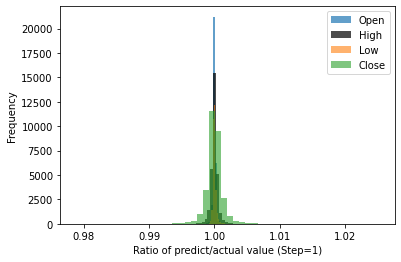

In [19]:
step=1
plt.hist(ohlc_pre[step, :, 0]/ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1]/ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2]/ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3]/ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

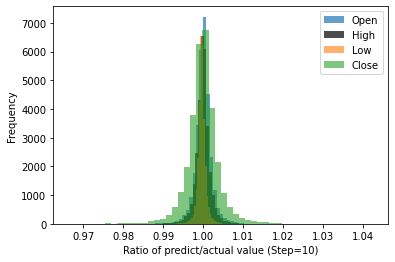

In [20]:
step=10
plt.hist(ohlc_pre[step, :, 0]/ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1]/ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2]/ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3]/ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

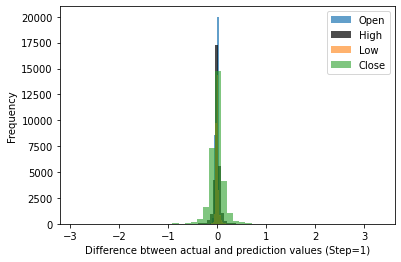

In [21]:
step=1
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

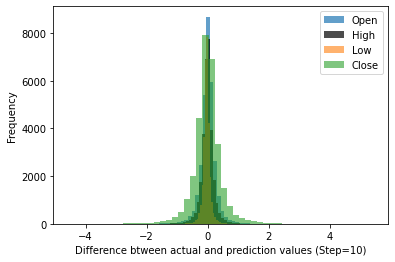

In [22]:
step=10
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [24]:
np.set_printoptions(precision=5)

print("==============Mean============")
print("Open", np.mean(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.mean(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.mean(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.var(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.var(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

==============Mean============
Open [ 0.      -0.00176  0.00147  0.0021   0.00357  0.00463  0.0058   0.00694
  0.00811  0.0093   0.01051]
High [ 0.      -0.00054 -0.00118 -0.0017  -0.00223 -0.00274 -0.00324 -0.00374
 -0.00425 -0.00474 -0.00522]
Low [ 0.      -0.00056 -0.0037  -0.00797 -0.01216 -0.01647 -0.02075 -0.02506
 -0.02936 -0.03367 -0.03798]
Close [ 0.      -0.00171 -0.00349 -0.00449 -0.00564 -0.00667 -0.00771 -0.00875
 -0.00979 -0.0108  -0.01181]
==============Var============
Open [0.      0.00073 0.00857 0.01557 0.02352 0.03123 0.03938 0.04763 0.05615
 0.06469 0.07332]
High [0.      0.00418 0.00902 0.01392 0.01865 0.0234  0.02808 0.03274 0.03732
 0.04187 0.04628]
Low [0.      0.00099 0.00272 0.00439 0.00605 0.00765 0.00927 0.01093 0.01265
 0.01433 0.01601]
Close [0.      0.02337 0.04516 0.06819 0.0902  0.11284 0.1353  0.15811 0.18074
 0.20302 0.22517]


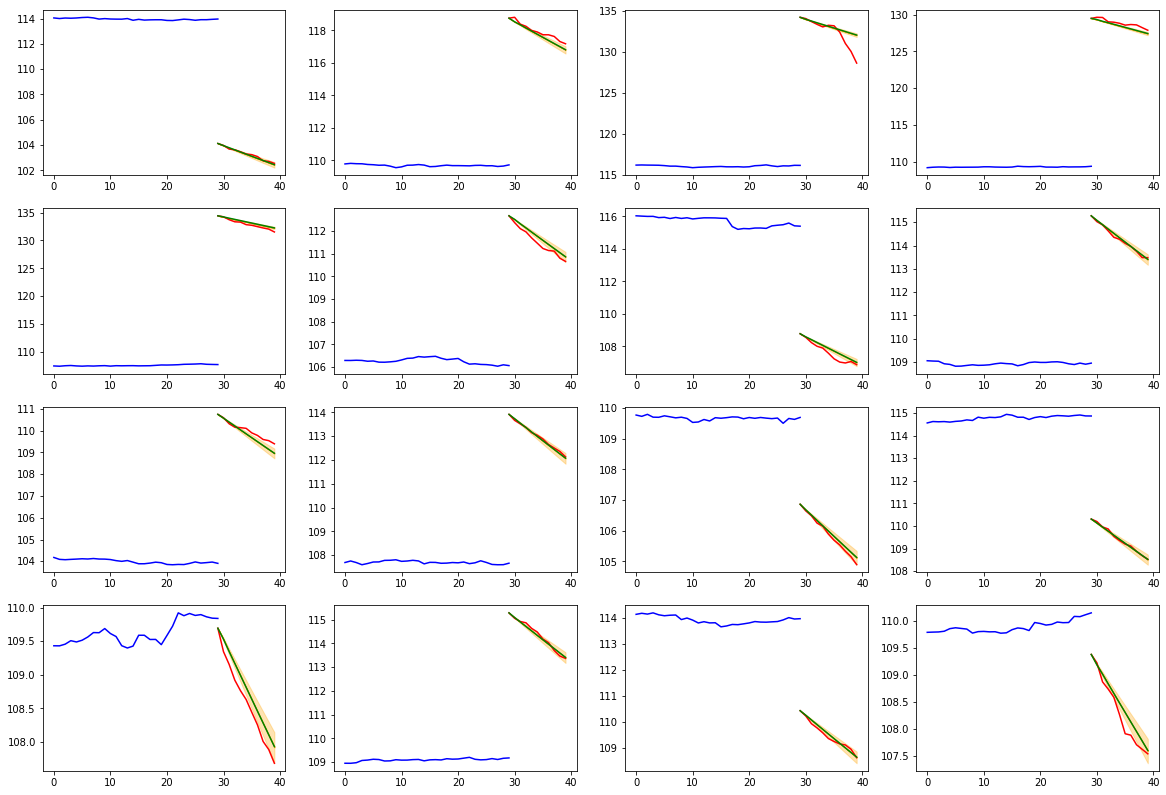

In [26]:
fig, axs = plt.subplots(4, 4, figsize=(20, 14))
close_mean = np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)
close_var = np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)

total_length = observation_length + prediction_length
x = np.arange(total_length)



for i, ax in enumerate(axs.flat):
    index = ds.get_actual_index(i+16)
    original_ohlc = df[ohlc_column[0]].iloc[index: index + observation_length]
    pred_value = ohlc_pre[:, i, 0]
    pred_add_mean = pred_value + close_mean
    pred_upper = pred_add_mean + close_var
    pred_lower = pred_add_mean - close_var

    ax.fill_between(x[observation_length -1:], pred_value, pred_add_mean, color="orange", alpha=0.9)
    ax.fill_between(x[observation_length -1:], pred_lower, pred_upper, color="orange", alpha=0.3)
    ax.plot(x[:observation_length], original_ohlc, color="blue")
    ax.plot(x[observation_length-1:], ohlc_ans[:, i, 0], color="red")
    ax.plot(x[observation_length-1:], pred_value, color="green")
plt.show()

!?!?!?!?